baseline.ipynp<br>
.. └ data<br>
.... ├ train<br>
.... ├ test<br>
.... ├ class_id_info.csv<br>
.... └ sample_submission.csv<br>

# 전처리 실험용
- crop 추가(11/18)

# 사용 패키지

In [30]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

# 데이터 로드

In [2]:
base_dir = '/home/jovyan/nas/1_user/mhyeom@agilesoda.ai/235855_병변 검출 AI 경진대회_data'

In [3]:
train_files = sorted(glob(f'{base_dir}/train/*'))
test_files = sorted(glob(f'{base_dir}/test/*'))

In [31]:
train_json_list = []
for file in tqdm(train_files):
    with open(file, "r") as json_file:
        train_json_list.append(json.load(json_file))

test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))

100%|██████████| 20874/20874 [00:57<00:00, 360.73it/s]


In [5]:
train_json_list[0].keys()

dict_keys(['file_name', 'shapes', 'imageData', 'imageHeight', 'imageWidth'])

In [15]:
train_json_list[0]

{'file_name': 'train_100000.json',
 'shapes': [{'label': '04_lymph',
   'points': [[303.991341991342, 368.83116883116884],
    [373.68831168831167, 368.83116883116884],
    [373.68831168831167, 493.5064935064935],
    [303.991341991342, 493.5064935064935]]}],
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJAAkADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHi

In [24]:
temp_img = Image.open(BytesIO(base64.b64decode(train_json_list[]['imageData'])))

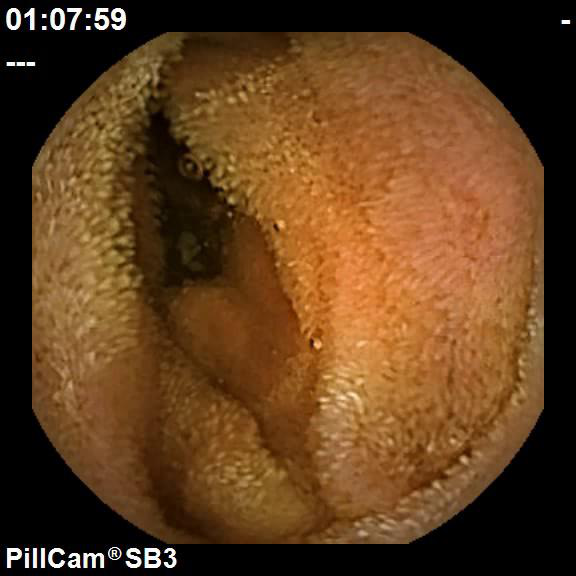

In [25]:
temp_img

In [28]:
transforms.Compose([
            transforms.ToTensor(),
        ])(temp_img).shape

torch.Size([3, 576, 576])

# EDA & 시각화

In [ ]:
label_count = {}
for data in train_json_list:
    for shape in data['shapes']:
        try:
            label_count[shape['label']]+=1
        except:
            label_count[shape['label']]=1

In [ ]:
label_count

{'04_lymph': 12002, '01_ulcer': 38958, '02_mass': 9760, '05_bleeding': 19498}

### Image crop

이미지 데이터는 base64형식으로 json파일에 포함되어있습니다.

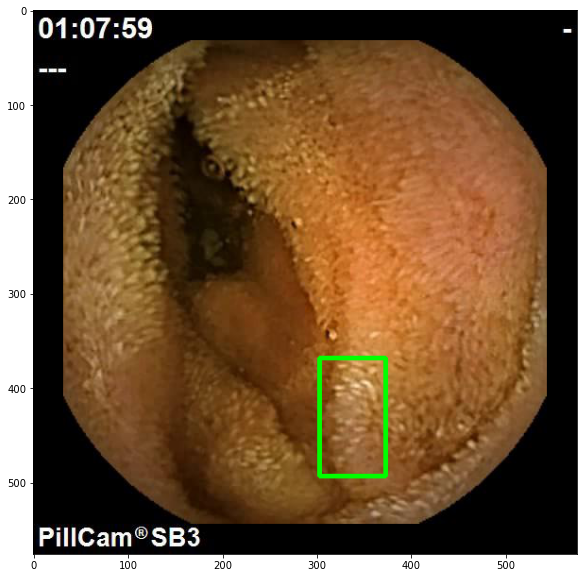

In [48]:
plt.figure(figsize=(10,10))
# for i in range(30):
#     plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
img = Image.open(BytesIO(base64.b64decode(train_json_list[0]['imageData'])))
img = np.array(img, np.uint8)
title = []
for shape in train_json_list[0]['shapes']:
    points = np.array(shape['points'], np.int32)
    cv2.polylines(img, [points], True, (0,255,0), 3)
    title.append(shape['label'])
title = ','.join(title)
plt.imshow(img)
#     plt.subplot(6,5,i+1).set_title(title)
plt.show()

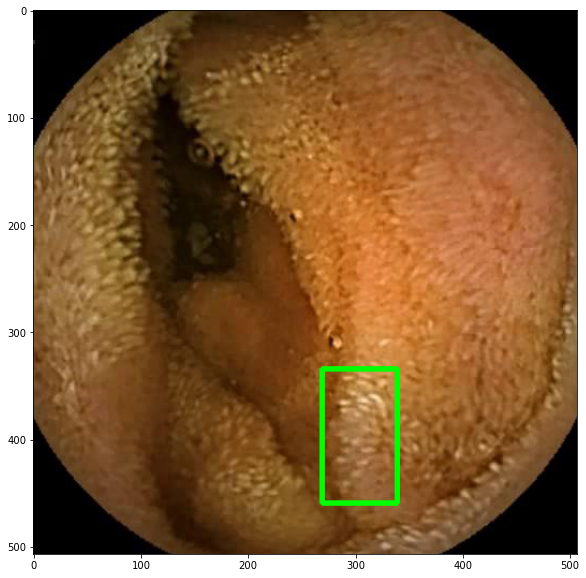

In [32]:
plt.figure(figsize=(10,10))
# for i in range(30):
#     plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
img = Image.open(BytesIO(base64.b64decode(train_json_list[0]['imageData'])))

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = img.size
 
# Setting the points for cropped image
left = int(width*0.06)
top = int(height*0.06)
right = int(width*0.94)
bottom = int(height*0.94)
 
# Cropped image of above dimension
# (It will not change original image)
img = img.crop((left, top, right, bottom))

img = np.array(img, np.uint8)
title = []
for shape in train_json_list[0]['shapes']:
    points = np.array([[x[0] - left, x[1] - top] for x in shape['points']], np.int32)
    cv2.polylines(img, [points], True, (0,255,0), 3)
    title.append(shape['label'])
title = ','.join(title)
plt.imshow(img)
#     plt.subplot(6,5,i+1).set_title(title)
plt.show()

In [42]:
img = Image.open(BytesIO(base64.b64decode(train_json_list[0]['imageData'])))

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = img.size
 
# Setting the points for cropped image
left = int(width*0.06)
top = int(height*0.06)
right = int(width*0.94)
bottom = int(height*0.94)
 
# Cropped image of above dimension
# (It will not change original image)
img = img.crop((left, top, right, bottom))

In [21]:
import PIL
from PIL import ImageEnhance

img = PIL.Image.open(BytesIO(base64.b64decode(train_json_list[0]['imageData'])))
bri_converter = ImageEnhance.Brightness(img)
shp_converter = ImageEnhance.Sharpness(img)
cnt_converter = ImageEnhance.Contrast(img)

In [12]:
bri_img = bri_converter.enhance(2)

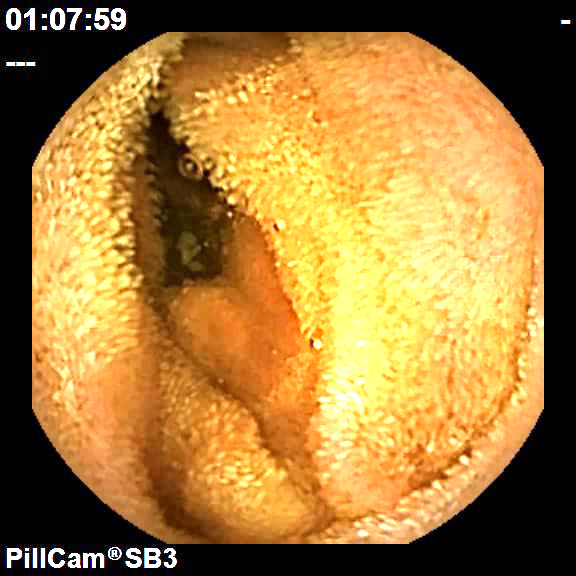

In [13]:
bri_img

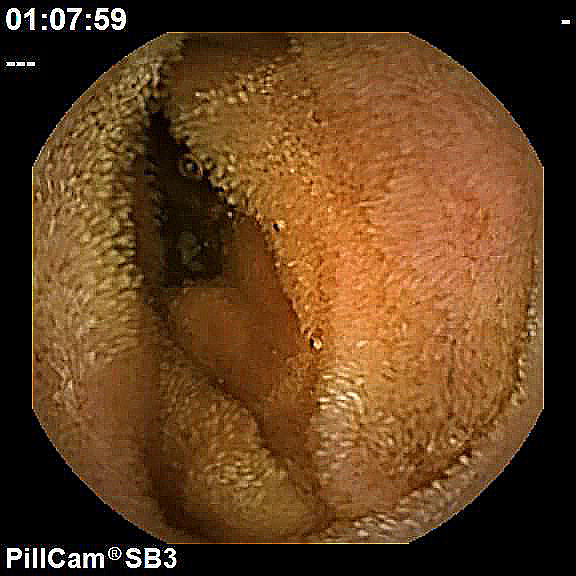

In [20]:
shp_img = shp_converter.enhance(8)
shp_img

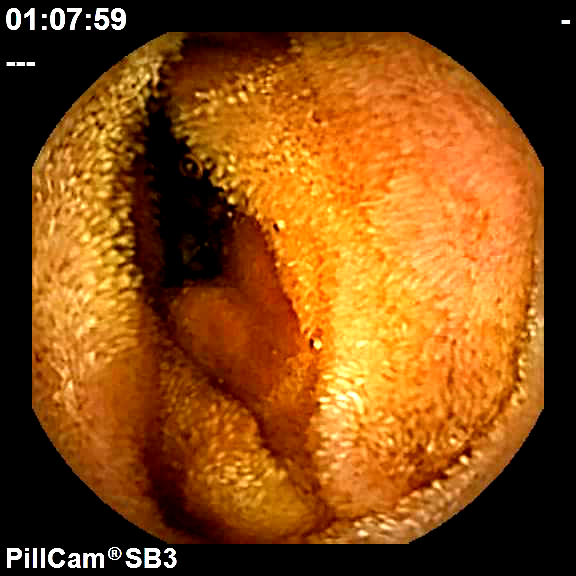

In [23]:
cnt_img = cnt_converter.enhance(2)
cnt_img

In [60]:
proc_train_json_list = train_json_list.copy()

In [ ]:
crop_img_list = []
crop_point_list = []
for i in tqdm(range(len(proc_train_json_list))):
    items = train_json_list[i]
    img = Image.open(BytesIO(base64.b64decode(items['imageData'])))
    width, height = img.size

    # Setting the points for cropped image
    left = int(width*0.06)
    top = int(height*0.06)
    right = int(width*0.94)
    bottom = int(height*0.94)
    img = img.crop((left, top, right, bottom))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    points = np.array([[x[0] - left, x[1] - top] for x in items['shapes'][0]['points']], np.int32)
    
    # Reassign preprocessed value
    train_json_list[i]['imageData'] = img_str
    train_json_list[i]['shapes'][0]['points'] = points
    del img_str, points, items

100%|██████████| 62622/62622 [09:15<00:00, 112.73it/s]


# 데이터셋

PyTroch https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html 를 활용하여 베이스라인을 작성하였습니다.

튜토리얼 코드에 맞게 데이터셋을 정의합니다.

In [62]:
class CustomDataset(Dataset):
    def __init__(self, json_list, mode='train'):
        self.mode = mode
        self.file_name = [json_file['file_name'] for json_file in json_list]
        if mode == 'train':
            self.labels = []
            for data in json_list:
                label = []
                for shapes in data['shapes']:
                    label.append(shapes['label'])
                self.labels.append(label)
            self.points = []
            for data in json_list:
                point = []
                for shapes in data['shapes']:
                    point.append(shapes['points'])
                self.points.append(point)
        self.imgs = [data['imageData'] for data in json_list]
        
        self.widths = [data['imageWidth'] for data in json_list]
        self.heights = [data['imageHeight'] for data in json_list]
        
        self.label_map ={
            '01_ulcer':1, '02_mass':2, '04_lymph':3, '05_bleeding':4
        }
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        file_name = self.file_name[i]
        img = Image.open(BytesIO(base64.b64decode(self.imgs[i])))
        img = self.transforms(img)
        
        target = {}
        if self.mode == 'train':
            boxes = []
            for point in self.points[i]:
                x_min = int(np.min(np.array(point)[:,0]))
                x_max = int(np.max(np.array(point)[:,0]))
                y_min = int(np.min(np.array(point)[:,1]))
                y_max = int(np.max(np.array(point)[:,1]))
                boxes.append([x_min, y_min, x_max, y_max])
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            label = [self.label_map[label] for label in self.labels[i]]

            masks = []
            for box in boxes:
                mask = np.zeros([int(self.heights[i]), int(self.widths[i])], np.uint8)
                masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

            masks = torch.tensor(masks, dtype=torch.uint8)

            target["boxes"] = boxes
            target["labels"] = torch.tensor(label, dtype=torch.int64)
            target["masks"] = masks
            target["area"] = area
            target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([i], dtype=torch.int64)
        if self.mode == 'test':
            target["file_name"] = file_name
        return img, target

In [63]:
train_dataset = CustomDataset(train_json_list, mode='train')
test_dataset = CustomDataset(test_json_list, mode='test')

In [64]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [65]:
train_dataset = CustomDataset(train_json_list, mode='train')

torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=12, shuffle=True, num_workers=16,
    collate_fn=collate_fn)

# 모델

Penn-Fudan Database for Pedestrian Detection and Segmentation로 학습된 Mask R-CNN 모델을 finetuning합니다.

In [66]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [67]:
num_classes = 5

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

In [69]:
gpu_num = 2
device = torch.device(f'cuda:{gpu_num}') if torch.cuda.is_available() else torch.device('cpu')

# class 4 + background 1 = 5
num_classes = 5

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 필요 클래스 및 함수 정의

## utils

In [70]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)
    
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))
        
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

## engine

In [71]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

# 학습
약 10GB의 GPU 메모리가 필요합니다.

학습은 1epoch만 진행하였습니다.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    torch.save(model.state_dict(),f'./Models/crop_model_eph{epoch+2}.torch')

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/5219]  eta: 8:04:31  lr: 0.000002  loss: 0.4649 (0.4649)  loss_classifier: 0.0859 (0.0859)  loss_box_reg: 0.0906 (0.0906)  loss_mask: 0.2732 (0.2732)  loss_objectness: 0.0115 (0.0115)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 5.5704  data: 4.4706  max mem: 0
Epoch: [0]  [ 100/5219]  eta: 1:28:04  lr: 0.000102  loss: 0.5021 (0.5201)  loss_classifier: 0.0964 (0.1012)  loss_box_reg: 0.1058 (0.1091)  loss_mask: 0.2880 (0.2929)  loss_objectness: 0.0112 (0.0125)  loss_rpn_box_reg: 0.0039 (0.0043)  time: 0.9890  data: 0.0308  max mem: 0
Epoch: [0]  [ 400/5219]  eta: 1:20:31  lr: 0.000402  loss: 0.5086 (0.5104)  loss_classifier: 0.0935 (0.0982)  loss_box_reg: 0.1029 (0.1058)  loss_mask: 0.2850 (0.2899)  loss_objectness: 0.0112 (0.0122)  loss_rpn_box_reg: 0.0039 (0.0042)  time: 1.0054  data: 0.0483  max mem: 0
Epoch: [0]  [ 500/5219]  eta: 1:18:39  lr: 0.000501  loss: 0.5060 (0.5091)  loss_classifier: 0.0951 (0.0976)  loss_box_reg: 0.1029 (0.1052)  loss_mask: 0.2914 (0.2898)  

In [ ]:
torch.save(model.state_dict(), PATH)

model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

# 추론 및 제출

각 테스트 파일에서 검출된 결과를 기록합니다.

하나의 테스트 파일에서 복수의 객체가 검출되었을 경우 복수의 결과를 기록합니다.

본 baseline에서는 score 0.8 이상의 결과만 기록하여 제출하였습니다.

[point1_x, point1_y] ~ [point4_x, point4_y]에 시계방향으로 객체의 4개 꼭지점 좌표를 기록합니다.

class_id는 제공된 class_id_info.csv의 class_id값을 기록합니다.

제출파일은 최대 30000줄까지 기록 가능합니다.

In [86]:
threshold = 0.8
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}
model.eval()
for img, target in tqdm(test_dataset):
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    idx = np.where(prediction['scores'].cpu().numpy() > threshold)[0]
    for i in idx:
        x_min, y_min, x_max, y_max = prediction['boxes'].cpu().numpy()[i]
        class_id = prediction['labels'].cpu().numpy()[i]
        confidence = prediction['scores'].cpu().numpy()[i]
        
        results['file_name'].append(target['file_name'])
        results['class_id'].append(class_id)
        results['confidence'].append(confidence)
        results['point1_x'].append(x_min)
        results['point1_y'].append(y_min)
        results['point2_x'].append(x_max)
        results['point2_y'].append(y_min)
        results['point3_x'].append(x_max)
        results['point3_y'].append(y_max)
        results['point4_x'].append(x_min)
        results['point4_y'].append(y_max)

 94%|█████████▍| 19655/20874 [19:25<01:08, 17.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [87]:
submission = pd.DataFrame(results)
submission.shape

(16325, 11)

In [88]:
submission.head()

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200001.json,1,0.906270,409.816254,196.918839,518.416382,196.918839,518.416382,308.453644,409.816254,308.453644
1,test_200001.json,1,0.897948,110.967255,335.587128,267.541473,335.587128,267.541473,482.073456,110.967255,482.073456
2,test_200002.json,2,0.832200,225.286133,347.847015,309.849365,347.847015,309.849365,460.932831,225.286133,460.932831
3,test_200003.json,2,0.974559,126.861816,0.000000,299.923431,0.000000,299.923431,201.126022,126.861816,201.126022
4,test_200006.json,1,0.897539,241.955292,414.012939,395.021576,414.012939,395.021576,541.709778,241.955292,541.709778


In [81]:
submission.to_csv('./crop_eph1.csv', index=False)

In [89]:
submission.to_csv('./Results/crop_eph3.csv', index=False)